In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import gridspec

xr.set_options(keep_attrs=True)


## Init dataset
dimension:
- time (01/01/2000 until from 01/12/2020)

In [2]:
time = pd.date_range(
        "01/2000",
        periods=20*12,
        freq=pd.DateOffset(months=1),
    )

amoc_dataset = xr.Dataset(
    data_vars=dict(),
    coords=dict(
        time=(["time"],time),
    ),
    attrs=dict(
        description="Aptherm Group Project to calculate the AMOC strength"
        ),
)


## Load datasets from all groups and adjust dimension names

In [3]:
DATAFOLDER = "data/"
FIGUREFOLDER = "figures/"

def RenameDimensionsAndVariables(dataset, dims_dict = dict(), vars_dict = False) :
    try:
        # rename the dimensions
        dataset = dataset.rename_dims(dims_dict)
        # rename coords assosiatet with dimensions
        try :
            dataset = dataset.rename_vars(dims_dict)
        except Exception as E :
            print(E)
        # rename the variables if necessary
        if vars_dict :
            dataset = dataset.rename_vars(vars_dict)
        return dataset
    except Exception as E :
        print(E)
        return None

# ============
# HYDROLOGICAL 
# group 1 and 2
hydrographic_mean = xr.open_dataset(DATAFOLDER + "group1_mean_transport.nc")
hydrographic_mean = RenameDimensionsAndVariables(
            dataset = hydrographic_mean,
            dims_dict = dict(
                LONGITUDE = "longitude",
                PRESSURE = "pressure",
                ),
            vars_dict = dict(
                __xarray_dataarray_variable__ = "hydrographic_mean"
                ))

hydrographic_climatology = xr.open_dataset(DATAFOLDER + "group1_climatology_transport.nc")
hydrographic_climatology = RenameDimensionsAndVariables(
            dataset = hydrographic_climatology,
            dims_dict = dict(
                LONGITUDE = "longitude",
                PRESSURE = "pressure",
                TIME = "month"
                ),
            vars_dict = dict(
                __xarray_dataarray_variable__ = "hydrographic_climatology"
                ))

hydrographic_variability = xr.open_dataset(DATAFOLDER + "group2_variability_interior_transport.nc")
hydrographic_variability = RenameDimensionsAndVariables(
            dataset = hydrographic_variability,
            dims_dict= 
            dict(
                lon = "longitude",
                p = "pressure",
            )
            )

# ============
# western boundary current
# group 3
western_boundary = xr.open_dataset(DATAFOLDER + "group3_western_boundary_transport.nc")
western_boundary_monthly = western_boundary.resample(time="1MS").mean(dim="time")
western_boundary_monthly_std = western_boundary.resample(time="1MS").std(dim="time")

# ============
# ekman transport
# group 5
ekman_transport = xr.open_dataset(DATAFOLDER + "group5_ekmann_transport_drag_independent.nc")
ekman_transport_drag_dependent = xr.open_dataset(DATAFOLDER + "group5_ekmann_transport_drag_dependent.nc")

### Insert monthly ekman transport in Sv into the amoc dataset

In [6]:
amoc_dataset["ekman_transport"] = (1e-6*ekman_transport.volume_transport_y).where(ekman_transport.atlantic_mask).mean("latitude").sum('longitude')
amoc_dataset.ekman_transport.attrs = {
        ** dict(
        long_name = 'ekman transport',
        label = 'ekman'),
        ** ekman_transport.volume_transport_y.attrs
    }
amoc_dataset["ekman_transport_drag_dependent"] = (1e-6*ekman_transport_drag_dependent.volume_transport_y).where(ekman_transport_drag_dependent.atlantic_mask).mean("latitude").sum('longitude')
ekman_transport_drag_dependent_attrs = {
    ** dict(
        label = r'ekman ($c_D(U)$)'),
    ** ekman_transport_drag_dependent.volume_transport_y.attrs
    }

amoc_dataset.ekman_transport_drag_dependent.attrs = ekman_transport_drag_dependent_attrs

amoc_dataset

<xarray.Dataset>
Dimensions:                         (time: 240)
Coordinates:
  * time                            (time) datetime64[ns] 2000-01-01 ... 2019...
Data variables:
    ekman_transport                 (time) float32 nan nan nan ... nan nan nan
    ekman_transport_drag_dependent  (time) float32 nan nan nan ... nan nan nan
Attributes:
    description:  Aptherm Group Project to calculate the AMOC strength

### Create mean and std monthly transport of western boundary current

In [7]:
''' insert ekman_transport in Sv and westernboundary current to amoc dataset '''
western_boundary_attrs = dict(
    latitude = "11 deg S",
    longitude = "36 deg W - 34.8 deg W",
    depth = "0 - 2000 m",
    unit = "Sv",
    unit_full = "Sverdup are 1e6 m^3/s",
)
''' For the mean of the Western boundary transport it only makes a minor difference when to resample'''
print('Total difference in mean western boundary transport between adding before - after resample \n{:.3f} Sv'.format( 
        np.sum(( 
            western_boundary.Transport_pos + western_boundary.Transport_neg).resample(time="1MS").mean(dim="time") 
            - (western_boundary.Transport_pos.resample(time="1MS").mean(dim="time") + western_boundary.Transport_neg.resample(time="1MS").mean(dim="time"))
            ).values
        )
    )

'''No need for the single pos and neg. transport'''
# amoc_dataset['western_boundary_pos'] = western_boundary.Transport_pos.resample(time="1MS").mean(dim="time")
# amoc_dataset.western_boundary_pos.attrs = {
#         **western_boundary_attrs,
#         **dict(description = "Western boundary transport of the Brazil current in the upper layer towards the north",
#                 label = "Western boundary pos."
#                 )}

# amoc_dataset['western_boundary_neg'] = western_boundary.Transport_neg.resample(time="1MS").mean(dim="time")
# amoc_dataset.western_boundary_neg.attrs = {
#         **western_boundary_attrs,
#         **dict(description = "Western boundary transport of the Brazil under current in the lower layer towards the south",
#                 label = "Western boundary transport south"
#                 )}

amoc_dataset['western_boundary'] = (western_boundary.Transport_pos + western_boundary.Transport_neg).resample(time="1MS").mean(dim="time")
amoc_dataset.western_boundary.attrs = {
        **western_boundary_attrs,
        **dict(description = "Western boundary transport at 11 deg S",
                long_name = "Western boundary transport total",
                label = "WBT total"
                )}

'''regarding the std of the western boundary current there needs to be defined how to calulate it'''


print('Total difference in std of western boundary transport between adding before - after resample \n{:.3f} Sv'.format( 
        np.sum(( 
            western_boundary.Transport_pos + western_boundary.Transport_neg).resample(time="1MS").std(dim="time") 
            - (western_boundary.Transport_pos.resample(time="1MS").std(dim="time") + western_boundary.Transport_neg.resample(time="1MS").std(dim="time"))
            ).values
        )
    )
print('''regarding the std of the western boundary current there needs to be defined how to calulate it''')

# it is sufficient to calculate the standard deviation based on the combined transport, as they were both derived from the same dataset and are independent of each other.
# Thus the total std. is calc. after adding both.
amoc_dataset['western_boundary_std'] = (western_boundary.Transport_pos + western_boundary.Transport_neg).resample(time= "1MS").std("time")
amoc_dataset['western_boundary_std'] = (western_boundary.Transport_pos.resample(time="1MS").std(dim="time") + western_boundary.Transport_neg.resample(time="1MS").std(dim="time"))
amoc_dataset.western_boundary_std.attrs = {
        **western_boundary_attrs,
        **dict(description = "Western boundary transport monthly standard deviation from daily to monthly mean calculation",
                long_name = "Western boundary transport std",
                label = "WBT std"
                )}


Total difference in mean western boundary transport between adding before - after resample 
-0.178 Sv
Total difference in std of western boundary transport between adding before - after resample 
-108.315 Sv
regarding the std of the western boundary current there needs to be defined how to calulate it


## Interior transport
1. add interior variability to the amoc dataset
2. calc interior mean from group1 and use it for amoc dataset

In [8]:
interior_attrs = dict(
    latitude = "11 deg S",
    longitude = "34.8 deg W to 12.5°E",
    depth = "0 - 2000 m",
    unit = "Sv",
    unit_full = "Sverdup are 1e6 m^3/s",
    )

'''determine that hydrographic_variablity wont be changed when transforming from mid of month to beginning of month'''
print(
    "The difference of interior variability before and after resample:\n{:.3f} Sv".format(
        np.sum(hydrographic_variability.integrated_transport.resample(time = "1MS").mean("time").values - hydrographic_variability.integrated_transport.values)
    )
)
amoc_dataset['interior_variability'] = hydrographic_variability.integrated_transport.resample(time = "1MS").mean("time")
amoc_dataset.interior_variability.attrs = {**hydrographic_variability.integrated_transport.attrs,
                **interior_attrs,
                **dict(
                    long_name = "Interior transport variability",
                    label = "Interior var.",
                    )
                }

# 2. add mean interior from group 1 to amoc dataset
amoc_dataset['interior_mean'] = 13.8 + 0*hydrographic_variability.integrated_transport.resample(time = "1MS").mean("time")
amoc_dataset.interior_mean.attrs = {**hydrographic_variability.integrated_transport.attrs,
                **interior_attrs,
                **dict(
                    long_name = "Interior transport mean",
                    label = "Interior mean"
                    )
                }

# 2. add mean interior from group 1 to amoc dataset
amoc_dataset['interior'] = amoc_dataset.interior_variability + amoc_dataset.interior_mean
amoc_dataset.interior.attrs = {**hydrographic_variability.integrated_transport.attrs,
                **interior_attrs,
                **dict(
                    long_name = "Interior transport variablility plus mean",
                    label = "Interior"
                    )
                }


The difference of interior variability before and after resample:
0.000 Sv


## calculate total transport 

In [23]:
# to combine the missing data it might help to combine with nans replaced by zeros or whatever
replace_nan_with_other = lambda data, x= np.nan : data.where(~np.isnan(data), other = x)
''' need to decide how to handle the missing WBC data '''

# 2. add mean interior from group 1 to amoc dataset
amoc_dataset['total'] = replace_nan_with_other(amoc_dataset.interior) + \
                        replace_nan_with_other(amoc_dataset.ekman_transport_drag_dependent) + \
                        replace_nan_with_other(amoc_dataset.western_boundary)
amoc_dataset.total.attrs = {
                **dict(
                    unit = "Sv",
                    long_name = "Total transport variablility plus mean",
                    label = "Total"
                    )
                }

amoc_dataset

<xarray.Dataset>
Dimensions:                         (time: 240)
Coordinates:
  * time                            (time) datetime64[ns] 2000-01-01 ... 2019...
Data variables:
    ekman_transport                 (time) float32 nan nan nan ... nan nan nan
    ekman_transport_drag_dependent  (time) float32 nan nan nan ... nan nan nan
    western_boundary                (time) float64 nan nan nan ... 10.58 nan nan
    western_boundary_std            (time) float64 nan nan nan ... 8.948 nan nan
    interior_variability            (time) float64 nan nan nan ... nan nan nan
    interior_mean                   (time) float64 nan nan nan ... nan nan nan
    interior                        (time) float64 nan nan nan ... nan nan nan
    total                           (time) float64 nan nan nan ... nan nan nan
Attributes:
    description:  Aptherm Group Project to calculate the AMOC strength

## Create a temporal plot and a seasonal cyle plot

In [30]:
''' Define necessary plot functions used for the final two plots'''

def plot_timeseries(data, ax, kwargs = dict()) :
    
    # use the passed kwarg label for all the plots
    if "label" not in kwargs:
        kwargs["label"] = data.attrs["label"]
    if "zorder" not in kwargs:
        kwargs["zorder"] = 10
    if "alpha" not in kwargs:
        kwargs['alpha'] = 1
    
    ax.plot(
            data.time,
            data.values,
            **kwargs
            )

def plot_seasonalcycle(data, ax, kwargs = dict(), scatter_plot = True):

    # use the passed kwarg label for all the plots
    if "label" not in kwargs:
        kwargs["label"] = data.attrs["label"]
    if "zorder" not in kwargs:
        kwargs["zorder"] = 10
    if "alpha" not in kwargs:
        kwargs['alpha'] = 1
    
    # for the second axes object plot for each of the transport the seasonal cyle and for each month all the values as scatters
    ax.plot(
            data.groupby("time.month").mean("time").month, 
            data.groupby("time.month").mean("time").values,
            **kwargs
            )
    # delete label for the scatter plot and change alpha and zorder for the scatter plot
    kwargs.pop("label")
    kwargs['alpha'] = 0.2
    kwargs["zorder"] = 5
    
    # only plot the scatter for each year if wanted:
    if scatter_plot is True:
        for year in np.unique(amoc_dataset.time.dt.year.values) :
            ax.scatter(data.time.dt.month.values, 
                        data.where(data.time.dt.year == year).values,
                        **kwargs)

def plot_std(data, data_std, ax, kwargs = dict()):
    # use the passed kwarg label for all the plots
    if "label" not in kwargs:
        kwargs["label"] = data.attrs["label"]
    if "zorder" not in kwargs:
        kwargs["zorder"] = 5
    if "alpha" not in kwargs:
        kwargs['alpha'] = 0.3
    

    ax.fill_between(
            x = data.time,
            y1 = (data - data_std).values,
            y2 = (data + data_std).values,
            **kwargs
            )

def plot_data(data, ax1, ax2, kwargs = dict(), scatter_plot = True):
    plot_timeseries(data, ax1, kwargs = kwargs)
    plot_seasonalcycle(data, ax2, kwargs = kwargs, scatter_plot = scatter_plot)

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def plot_from_amoc_dataset(amoc_dataset, fig, ax1, ax2,  colors, markers):
    # ---- EKMAN ----
    idx = 0
    plot_data(amoc_dataset.ekman_transport, 
                ax1 = ax1, ax2 = ax2, 
                kwargs= dict(
                            color = lighten_color(colors[idx], amount = 0.5), 
                            marker = markers[idx],
                            linestyle = ":",
                            )
                )

    plot_data(amoc_dataset.ekman_transport_drag_dependent, 
                ax1 = ax1, ax2 = ax2, 
                kwargs= dict(
                            color = colors[idx], 
                            marker = markers[idx],
                            linestyle = ":",
                            )
                )
    # ---- WESTERN BOUNDARY ----
    idx += 1
    plot_data(amoc_dataset.western_boundary, 
                ax1 = ax1, ax2 = ax2, 
                kwargs= dict(
                            color = colors[idx], 
                            marker = markers[idx],
                            linestyle = ":"
                            )
                )
    #also plot std of western boundary current
    plot_std(data = amoc_dataset.western_boundary, data_std = amoc_dataset.western_boundary_std, 
                ax = ax1,
                kwargs= dict(
                            # alpha = 0.2,
                            label = "WBC std",
                            color = lighten_color(colors[idx], amount = 0.5),
                            )
                )

    # ---- INTERIOR ----
    idx += 1
    plot_data(amoc_dataset.interior, 
                ax1 = ax1, ax2 = ax2, 
                kwargs= dict(
                            color = colors[idx], 
                            marker = markers[idx],
                            linestyle = ":"
                            )
                )

    # ---- FULL ----
    idx += 1
    plot_data(amoc_dataset.total, 
                ax1 = ax1, ax2 = ax2,
                kwargs= dict(
                            color = colors[idx], 
                            marker = markers[idx],
                            zorder = 30,
                            linestyle = '--'
                            ),
                scatter_plot= False
                )



    ax1.grid(linestyle = "--", alpha = 0.5)
    ax1.set_title("Temporal evolution")
    ax1.set_xlabel(None)
    ax1.set_ylabel("Transport [Sv]")
    ax1.legend(ncol=2)

    ax2.grid()
    ax2.set_title("Seasonal cycle")
    ax2.set_xlabel("Month")
    ax2.yaxis.tick_right()
    ax2.legend(ncol=2)

    # ax3.set_ylim([first_valid_time, last_valid_time])
    fig.suptitle("Meridional transport at 11°S")

    for axs in [ax1,ax2] :
        axs.axhline(0, linestyle = "--", linewidth = 2, color = "k", alpha = 0.5, zorder = 30) 
        axs.grid(linestyle = "--", alpha = 0.5)

    return fig, ax1, ax2



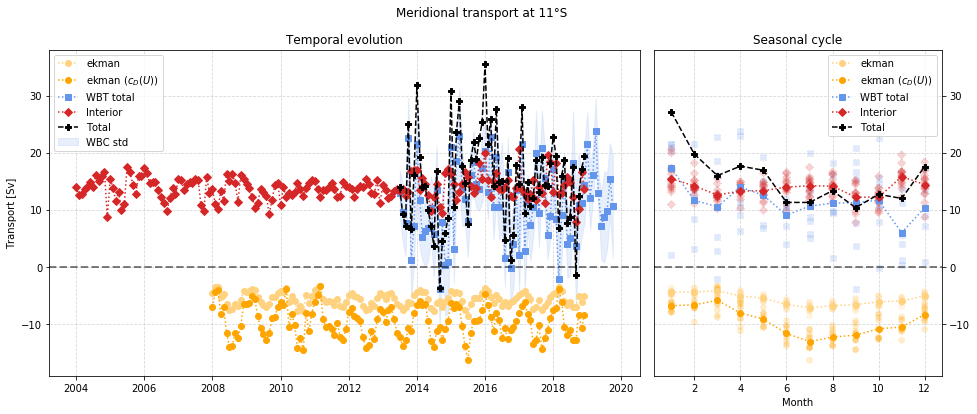

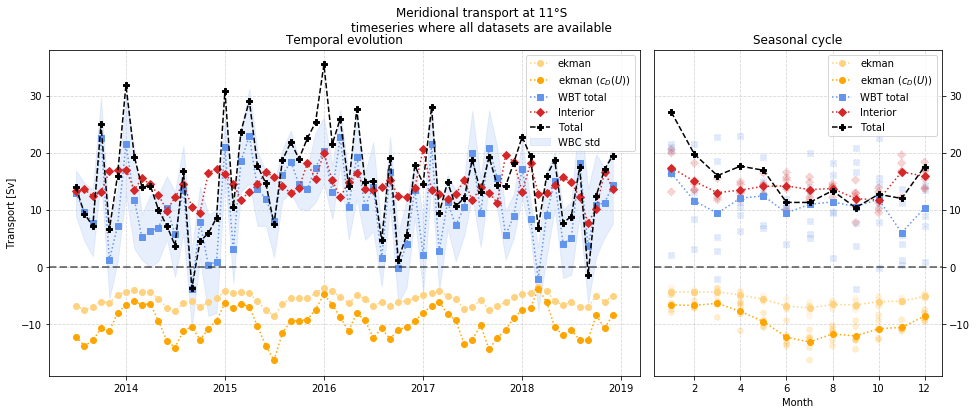

In [31]:
colors = ("orange", "cornflowerblue", "tab:red", "k")
markers = ('o', 's', 'D', 'P')

''' Plot the whole dataset '''
fig1 = plt.figure(figsize= (16,6))
gs = gridspec.GridSpec(1, 3, wspace=0.05, hspace=0.4)
ax1 = fig1.add_subplot(gs[0, 0:2])
ax2 = fig1.add_subplot(gs[0, 2], sharey = ax1)

fig1, ax1, ax2 = plot_from_amoc_dataset(amoc_dataset, fig = fig1, ax1 = ax1, ax2 = ax2, markers = markers, colors= colors)
fig1.suptitle("Meridional transport at 11°S")
fig1.savefig(FIGUREFOLDER + "MT_11S.svg")

# -----------------------------
''' Plot the only dataset for which total transport exists '''
first_valid_time = pd.Series.first_valid_index(amoc_dataset.time.where(~np.isnan(amoc_dataset.total)).to_pandas())
last_valid_time =pd.Series.last_valid_index(amoc_dataset.time.where(~np.isnan(amoc_dataset.total)).to_pandas())


fig2 = plt.figure(figsize= (16,6))
gs = gridspec.GridSpec(1, 3, wspace=0.05, hspace=0.4)
ax2_1 = fig2.add_subplot(gs[0, 0:2])
ax2_2 = fig2.add_subplot(gs[0, 2], sharey = ax2_1)

fig2, ax2_1, ax2_2 = plot_from_amoc_dataset(amoc_dataset.sel(time = slice(first_valid_time, last_valid_time)), fig = fig2, ax1 = ax2_1, ax2 = ax2_2, markers = markers, colors= colors)
fig2.suptitle("Meridional transport at 11°S\ntimeseries where all datasets are available")
fig2.savefig(FIGUREFOLDER + "MT_11S_zoomed.svg")


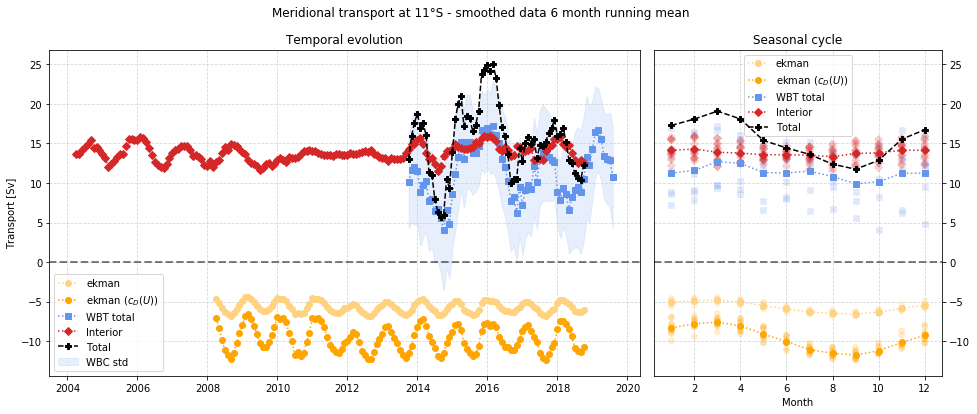

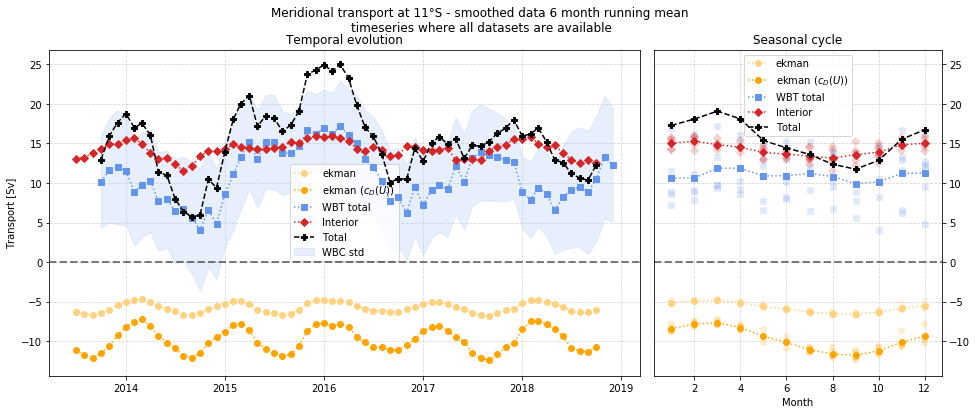

In [32]:
rolling_months = 6
amoc_rolledmean = amoc_dataset.rolling(time = rolling_months, center=True).mean()
for key in amoc_rolledmean:
    amoc_rolledmean[key].attrs = amoc_dataset[key].attrs

''' Plot the rolling mean of 3 month of dataset '''

fig3 = plt.figure(figsize= (16,6))
gs = gridspec.GridSpec(1, 3, wspace=0.05, hspace=0.4)
ax3_1 = fig3.add_subplot(gs[0, 0:2])
ax3_2 = fig3.add_subplot(gs[0, 2], sharey = ax3_1)

fig3, ax3_1, ax3_2 = plot_from_amoc_dataset(amoc_rolledmean, fig = fig3, ax1 = ax3_1, ax2 = ax3_2, markers = markers, colors= colors)
fig3.suptitle("Meridional transport at 11°S - smoothed data {:.0f} month running mean".format(rolling_months))
fig3.savefig(FIGUREFOLDER + "MT_11S_smooth.svg")

# -----------------------------
''' Plot the only dataset for which total transport exists '''
first_valid_time = pd.Series.first_valid_index(amoc_dataset.time.where(~np.isnan(amoc_dataset.total)).to_pandas())
last_valid_time =pd.Series.last_valid_index(amoc_dataset.time.where(~np.isnan(amoc_dataset.total)).to_pandas())


fig4 = plt.figure(figsize= (16,6))
gs = gridspec.GridSpec(1, 3, wspace=0.05, hspace=0.4)
ax4_1 = fig4.add_subplot(gs[0, 0:2])
ax4_2 = fig4.add_subplot(gs[0, 2], sharey = ax4_1)

fig4, ax4_1, ax4_2 = plot_from_amoc_dataset(amoc_rolledmean.sel(time = slice(first_valid_time, last_valid_time)), fig = fig4, ax1 = ax4_1, ax2 = ax4_2, markers = markers, colors= colors)
fig4.suptitle("Meridional transport at 11°S - smoothed data {:.0f} month running mean \ntimeseries where all datasets are available".format(rolling_months))
fig4.savefig(FIGUREFOLDER + "MT_11S_smooth_zoomed.svg")